In [76]:
import os
import gc
import pickle

import numpy as np
import pandas as pd
import polars as pl

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor

import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

Thanks to [@greysky](https://www.kaggle.com/greysky) for the data pre-processing work in his notebook [Enefit Generic Notebook](https://www.kaggle.com/code/greysky/enefit-generic-notebook/notebook).

In [2]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
class MonthlyKFold:
    def __init__(self, n_splits=3):
        self.n_splits = n_splits
        
    def split(self, X, y, groups=None):
        dates = 12 * X["year"] + X["month"]
        timesteps = sorted(dates.unique().tolist())
        X = X.reset_index()
        
        for t in timesteps[-self.n_splits:]:
            idx_train = X[dates.values < t].index
            idx_test = X[dates.values == t].index
            
            yield idx_train, idx_test
            
    def get_n_splits(self, X, y, groups=None):
        return self.n_splits
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

In [3]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target):
    df_data = (
        df_data
        .with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )
    )
    
    df_client = (
        df_client
        .with_columns(
            (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
        )
    )
    
    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns(
            (pl.col("date") + pl.duration(days=1)).cast(pl.Date)
        )
    )
    
    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(
            pl.col("datetime") + pl.duration(days=1)
        )
    )
    
    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )
    
    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col('datetime').dt.convert_time_zone("Europe/Bucharest").dt.replace_time_zone(None).cast(pl.Datetime("us")),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_historical = (
        df_historical
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col("datetime") + pl.duration(hours=37)
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_forecast_date = (
        df_forecast
        .group_by("datetime").mean()
        .drop("county")
    )
    
    df_forecast_local = (
        df_forecast
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    df_historical_date = (
        df_historical
        .group_by("datetime").mean()
        .drop("county")
    )
    
    df_historical_local = (
        df_historical
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        
        .join(df_forecast_date, on="datetime", how="left", suffix="_fd")
        .join(df_forecast_local, on=["county", "datetime"], how="left", suffix="_fl")
        .join(df_historical_date, on="datetime", how="left", suffix="_hd")
        .join(df_historical_local, on=["county", "datetime"], how="left", suffix="_hl")
        
        .join(df_forecast_date.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on="datetime", how="left", suffix="_fdw")
        .join(df_forecast_local.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on=["county", "datetime"], how="left", suffix="_flw")
        .join(df_historical_date.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on="datetime", how="left", suffix="_hdw")
        .join(df_historical_local.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on=["county", "datetime"], how="left", suffix="_hlw")
        
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=2))
              .rename({"target": "target_1"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=3))
              .rename({"target": "target_2"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=4))
              .rename({"target": "target_3"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=5))
              .rename({"target": "target_4"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=6))
              .rename({"target": "target_5"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=7))
              .rename({"target": "target_6"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=14))
              .rename({"target": "target_7"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        
        .with_columns(
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
            pl.col("datetime").dt.hour().alias("hour"),
            pl.col("datetime").dt.day().alias("day"),
            pl.col("datetime").dt.weekday().alias("weekday"),
            pl.col("datetime").dt.month().alias("month"),
            pl.col("datetime").dt.year().alias("year"),
        )
        
        .with_columns(
            pl.concat_str("county", "is_business", "product_type", "is_consumption", separator="_").alias("category_1"),
        )
        
        .with_columns(
            (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
            (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
            (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
            (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
        )
        
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        
        .drop("date", "datetime", "hour", "dayofyear")
    )
    
    return df_data
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

In [4]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
def to_pandas(X, y=None):
    cat_cols = ["county", "is_business", "product_type", "is_consumption", "category_1"]
    
    if y is not None:
        df = pd.concat([X.to_pandas(), y.to_pandas()], axis=1)
    else:
        df = X.to_pandas()    
    
    df = df.set_index("row_id")
    df[cat_cols] = df[cat_cols].astype("category")
    
    df["target_mean"] = df[[f"target_{i}" for i in range(1, 7)]].mean(1)
    df["target_std"] = df[[f"target_{i}" for i in range(1, 7)]].std(1)
    df["target_ratio"] = df["target_6"] / (df["target_7"] + 1e-3)
    
    return df
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

In [5]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
def lgb_objective(trial):
    params = {
        'n_iter'           : 1000,
        'verbose'          : -1,
        'random_state'     : 42,
        'objective'        : 'l2',
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'lambda_l1'        : trial.suggest_float('lambda_l1', 1e-2, 10.0),
        'lambda_l2'        : trial.suggest_float('lambda_l2', 1e-2, 10.0),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 4, 256),
        'max_depth'        : trial.suggest_int('max_depth', 5, 10),
        'max_bin'          : trial.suggest_int('max_bin', 32, 1024),
    }
    
    model  = lgb.LGBMRegressor(**params)
    X, y   = df_train.drop(columns=["target"]), df_train["target"]
    cv     = MonthlyKFold(1)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    
    return -1 * np.mean(scores)
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Global Variables

In [6]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
root = "/kaggle/input/predict-energy-behavior-of-prosumers"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 
                    'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', 
                    '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 
                    'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols  = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total',
                    'cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m',
                    'shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']

save_path = None
load_path = None
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Data I/O

In [7]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_historical  = pl.read_csv(os.path.join(root, "historical_weather.csv"), columns=historical_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)
df_target      = df_data.select(target_cols)

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_historical  = df_historical.schema
schema_target      = df_target.schema
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Feature Engineering

In [11]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
X, y = df_data.drop("target"), df_data.select("target")

X = feature_eng(X, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)

df_train = to_pandas(X, y)
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

In [13]:
df_train = df_train[df_train["target"].notnull()]

# EDA

In [9]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2018352 entries, 0 to 2018351
Data columns (total 137 columns):
 #    Column                                 Dtype   
---   ------                                 -----   
 0    county                                 category
 1    is_business                            category
 2    product_type                           category
 3    is_consumption                         category
 4    lowest_price_per_mwh                   float32 
 5    highest_price_per_mwh                  float32 
 6    eic_count                              float64 
 7    installed_capacity                     float32 
 8    euros_per_mwh                          float32 
 9    hours_ahead                            float32 
 10   temperature                            float32 
 11   dewpoint                               float32 
 12   cloudcover_high                        float32 
 13   cloudcover_low                         float32 
 14   cloudcover_mid       

In [19]:
# Sample size per group
sample_size = 100

# List of variables for which you want to sample data
variables_to_sample = ["county", "is_business", "product_type", "is_consumption", "month", "year"]

# Group by the specified variables and sample data from each group
sampled_data = df_train.groupby(variables_to_sample, group_keys=True).apply(lambda x: x.sample(min(len(x), sample_size)))

# Resetting the index of the sampled data
sampled_data = sampled_data.reset_index(drop=True)

# Now, 'sampled_data' contains a representative sample based on the specified variables
sampled_data.shape[0]

county                  278136
is_business             278136
product_type            278136
is_consumption          278136
lowest_price_per_mwh    277723
                         ...  
cos(hour)               278136
target                  278136
target_mean             276662
target_std              275904
target_ratio            269155
Length: 137, dtype: int64

In [42]:
num_cols = sampled_data.columns[sampled_data.dtypes == 'float32']
corr_mat = sampled_data[[*num_cols, 'target']].corr()

In [71]:
filt_corr_mat = corr_mat[np.abs(corr_mat['target']) > 0.05]
filt_corr_mat = filt_corr_mat[filt_corr_mat.index]

Text(0.5, 1.0, 'Correlation Heatmap')

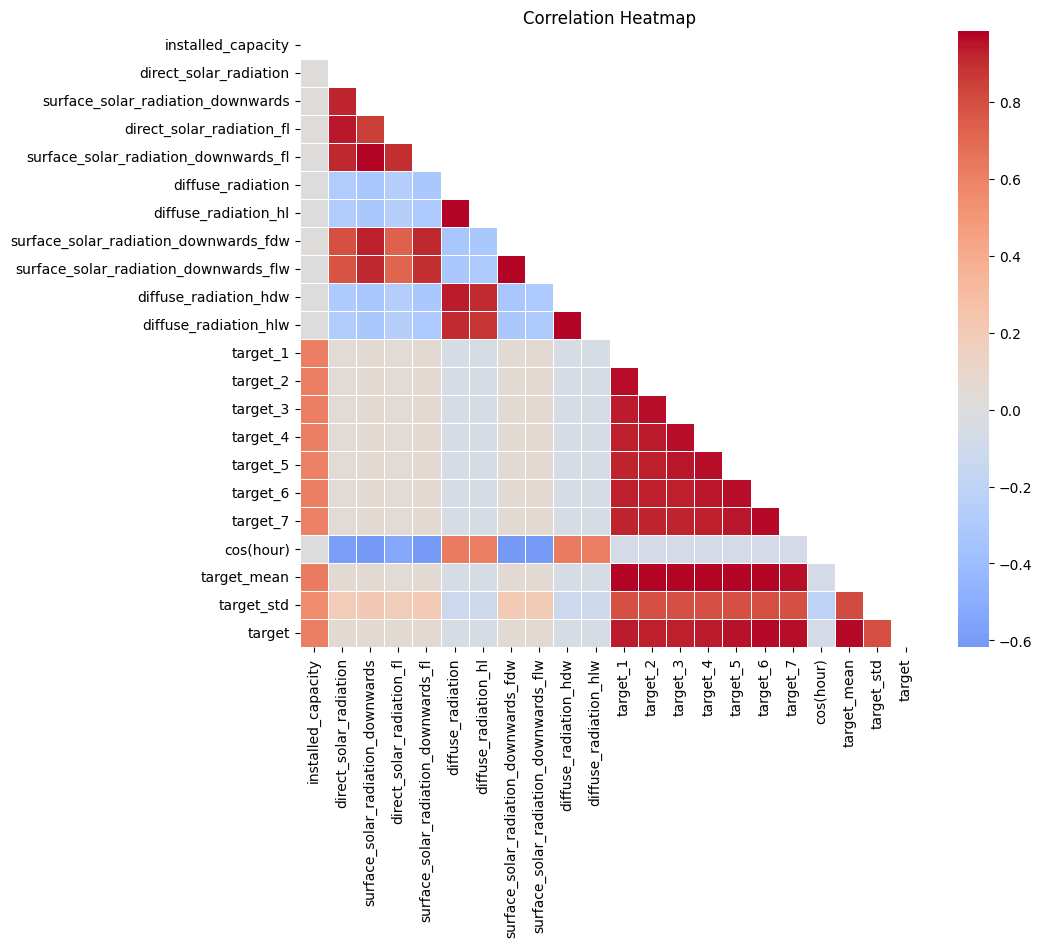

In [79]:
mask = np.triu(np.ones_like(filt_corr_mat, dtype=bool))
sns.heatmap(filt_corr_mat, cmap='coolwarm', mask=mask, linewidths=.5, center=0)
plt.title('Correlation Heatmap')

### HyperParam Optimization

In [ ]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
best_params = {
    'n_iter'           : 900,
    'verbose'          : -1,
    'objective'        : 'l2',
    'learning_rate'    : 0.05689066836106983,
    'colsample_bytree' : 0.8915976762048253,
    'colsample_bynode' : 0.5942203285139224,
    'lambda_l1'        : 3.6277555139102864,
    'lambda_l2'        : 1.6591278779517808,
    'min_data_in_leaf' : 186,
    'max_depth'        : 9,
    'max_bin'          : 813,
} # val score is 62.24 for the last month
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Validation

In [ ]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
'''result = cross_validate(
    estimator=lgb.LGBMRegressor(**best_params, random_state=42),
    X=df_train.drop(columns=["target"]), 
    y=df_train["target"],
    scoring="neg_mean_absolute_error",
    cv=MonthlyKFold(1),
)

print(f"Fit Time(s): {result['fit_time'].mean():.3f}")
print(f"Score Time(s): {result['score_time'].mean():.3f}")
print(f"Error(MAE): {-result['test_score'].mean():.3f}")'''
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Training

In [ ]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
if load_path is not None:
    model = pickle.load(open(load_path, "rb"))
else:
    model = VotingRegressor([
        ('lgb_1', lgb.LGBMRegressor(**best_params, random_state=100)), 
        ('lgb_2', lgb.LGBMRegressor(**best_params, random_state=101)), 
        ('lgb_3', lgb.LGBMRegressor(**best_params, random_state=102)), 
        ('lgb_4', lgb.LGBMRegressor(**best_params, random_state=103)), 
        ('lgb_5', lgb.LGBMRegressor(**best_params, random_state=104)), 
    ])
    
    model.fit(
        X=df_train.drop(columns=["target"]),
        y=df_train["target"]
    )

if save_path is not None:
    with open(save_path, "wb") as f:
        pickle.dump(model, f)
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Prediction

In [ ]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [ ]:
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    
    test = test.rename(columns={"prediction_datetime": "datetime"})
    
    df_test           = pl.from_pandas(test[data_cols[1:]], schema_overrides=schema_data)
    df_client         = pl.from_pandas(client[client_cols], schema_overrides=schema_client)
    df_gas            = pl.from_pandas(gas_prices[gas_cols], schema_overrides=schema_gas)
    df_electricity    = pl.from_pandas(electricity_prices[electricity_cols], schema_overrides=schema_electricity)
    df_new_forecast   = pl.from_pandas(forecast_weather[forecast_cols], schema_overrides=schema_forecast)
    df_new_historical = pl.from_pandas(historical_weather[historical_cols], schema_overrides=schema_historical)
    df_new_target     = pl.from_pandas(revealed_targets[target_cols], schema_overrides=schema_target)
    
    df_forecast       = pl.concat([df_forecast, df_new_forecast]).unique()
    df_historical     = pl.concat([df_historical, df_new_historical]).unique()
    df_target         = pl.concat([df_target, df_new_target]).unique()
    
    X_test = feature_eng(df_test, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)
    X_test = to_pandas(X_test)
    
    sample_prediction["target"] = model.predict(X_test).clip(0)
    
    env.predict(sample_prediction)